## Imports

In [1]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EarlyStopping

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import numpy as np

import os

from TurbulenceNetwork import TurbulenceNetwork
from TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from Model_utils import *
from Data_utils import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2


## Misc Utilities

In [2]:
class MAPELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MAPELoss, self).__init__()
        self.eta = 1e-3

    def forward(self, y_pred, y_true):
        l = torch.abs((y_true - y_pred)) / (torch.abs(y_true) + self.eta)

        return torch.mean(l)

class RMSELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(RMSELoss, self).__init__()
        self.eta = 1e-8

    def forward(self, y_pred, y_true):
        l = torch.sqrt(torch.mean(torch.pow((y_true - y_pred), 2)))

        return l


## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/TurbulenceClosureDataGenerator.py:85: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)*np.sqrt(-a**3/27))


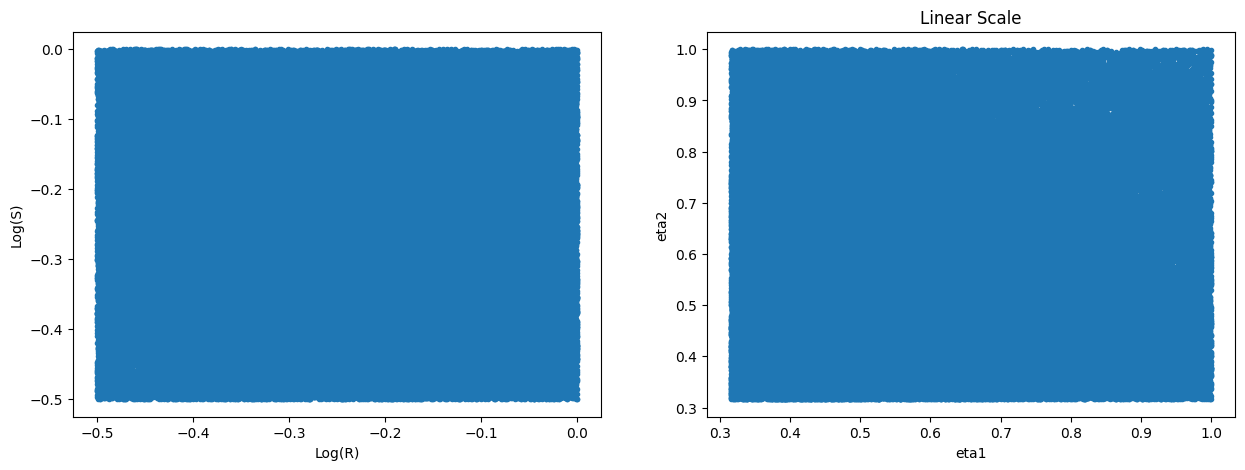

In [3]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 120_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 40_000, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(np.log10(np.sqrt(etas_train)))

## Network Training

In [4]:
# Defining model parameters
checkpoint_dir = './Model_Checkpoints/'

callbacks = [EarlyStopping(patience=15, threshold=0.0001, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
            Checkpoint(monitor='valid_loss_best', f_params='TurbulenceNetwork.pt', dirname=checkpoint_dir)
]

net_params = {
        "input_dim": 2,
        "output_dim": 3,
        "num_layers": 8,
        "nodes": [100]*8,
        "dropout": 0.05,
}

train_params = {
        "criterion": nn.L1Loss,
        "optimizer": torch.optim.Adam,
        "optimizer__weight_decay": 0.00001,
        "lr": 0.0001,
        "batch_size": 64,
        "max_epochs": 400,
        "device": device,
        "iterator_train__shuffle": True,
        "iterator_train__num_workers": 4,
        "iterator_train__pin_memory": True,
        "iterator_valid__shuffle": False,
        "iterator_valid__num_workers": 4,
        "iterator_valid__pin_memory": True,
        "verbose": 0,
        "callbacks": callbacks,
}

In [7]:
num_data_points = np.arange(10_000, etas_train.shape[0] + 10_000, 10_000)
test_criteria = nn.L1Loss()
num_runs = 10
run_losses = []

data_indexes = []
for i in range(1, etas_train.shape[0]//10_000 + 1):
        data_indexes.append(np.random.choice(etas_train.shape[0], 10_000*i, replace=False))


for i in range(num_runs):
        test_losses = []
        print(f"Run {i+1}/{num_runs}")
        for data_index in data_indexes:
                print(f"\tTraining with {data_index.shape[0]} data points")
                num_data_in_k = data_index.shape[0]//1000
                callbacks = [EarlyStopping(patience=10, threshold=0.0001, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
                        Checkpoint(monitor='valid_loss_best', f_params=f'TurbulenceNetwork_{num_data_in_k}.pt', dirname='./Model_Checkpoints/')
                ]
                train_params['callbacks'] = callbacks


                train_x, train_y = etas_train[data_index], gs_train[data_index]


                net = create_skorch_model(TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
                net = net.fit(train_x, train_y)


                net.load_params(f_params=checkpoint_dir+f'TurbulenceNetwork_{num_data_in_k}.pt')
                test_losses.append(test_criteria(torch.tensor(net.predict(etas_test)),torch.tensor(gs_test)))
                print(f"\t\tTest loss: {test_losses[-1]}")
        run_losses.append(test_losses)


Run 1/10
	Training with 10000 data points
		Test loss: 0.00426706200993984
	Training with 20000 data points
		Test loss: 0.004056396492646431
	Training with 30000 data points
		Test loss: 0.003714981367629933
	Training with 40000 data points
		Test loss: 0.002712507415467169
	Training with 50000 data points
		Test loss: 0.0018953096938628651
	Training with 60000 data points
		Test loss: 0.0031011771029701737
	Training with 70000 data points
		Test loss: 0.001670512315213158
	Training with 80000 data points
		Test loss: 0.0029765075547595996
	Training with 90000 data points
		Test loss: 0.0014986854959540608
	Training with 100000 data points
		Test loss: 0.0029222109611362537
	Training with 110000 data points
		Test loss: 0.002176715903893258
	Training with 120000 data points
		Test loss: 0.004149927491219408
Run 2/10
	Training with 10000 data points
		Test loss: 0.003928086321169549
	Training with 20000 data points
		Test loss: 0.005204355996346217
	Training with 30000 data points
		Te

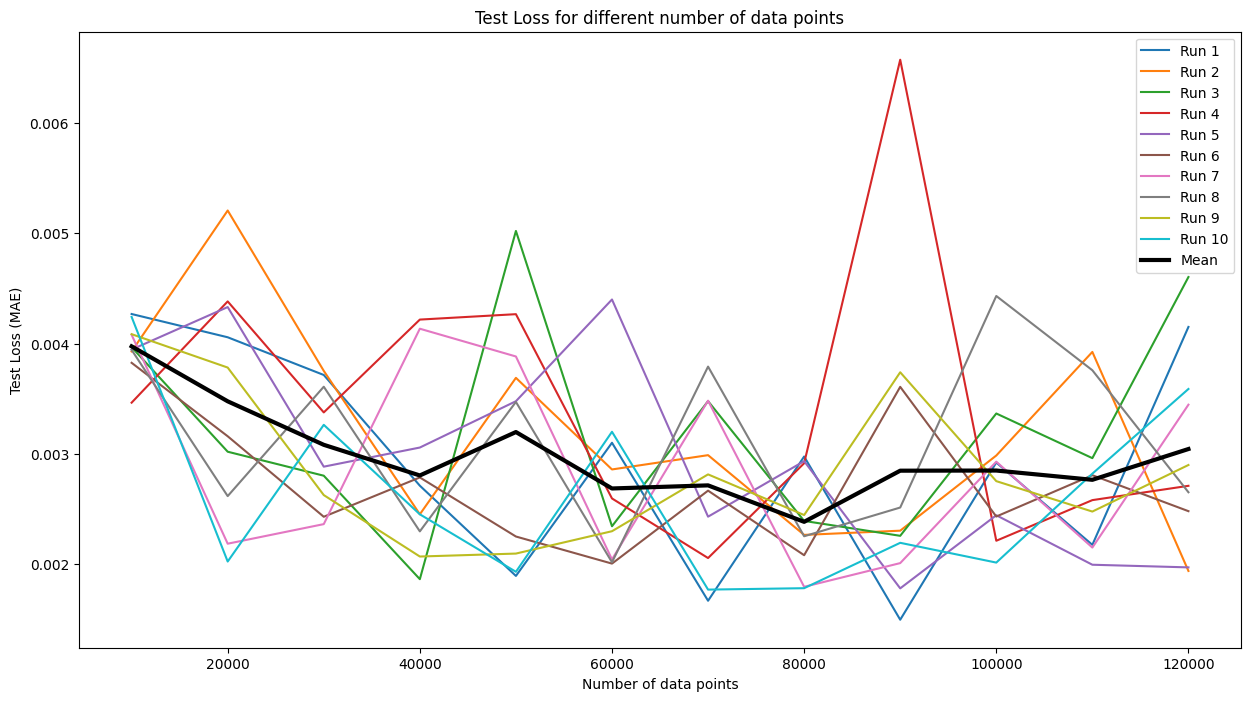

In [16]:

plt.figure(figsize=(15,8))
plt.title("Test Loss for different number of data points")
plt.xlabel("Number of data points")
plt.ylabel("Test Loss (MAE)")

for i,loss in enumerate(run_losses):
        plt.plot(num_data_points, loss, label=f"Run {i+1}")


run_loss = np.array(run_losses)
mean_losses = np.mean(run_losses, axis=0)
plt.plot(num_data_points, mean_losses, label="Mean", color='black', linewidth=3)
plt.legend()
plt.show()

## Reinitializing Trained Model

In [5]:
checkpoint_dir = './Model_Checkpoints'

net = reinitialize_model('TurbulenceNetwork_120.pt', checkpoint_dir, TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)


## Generating Statistics Data

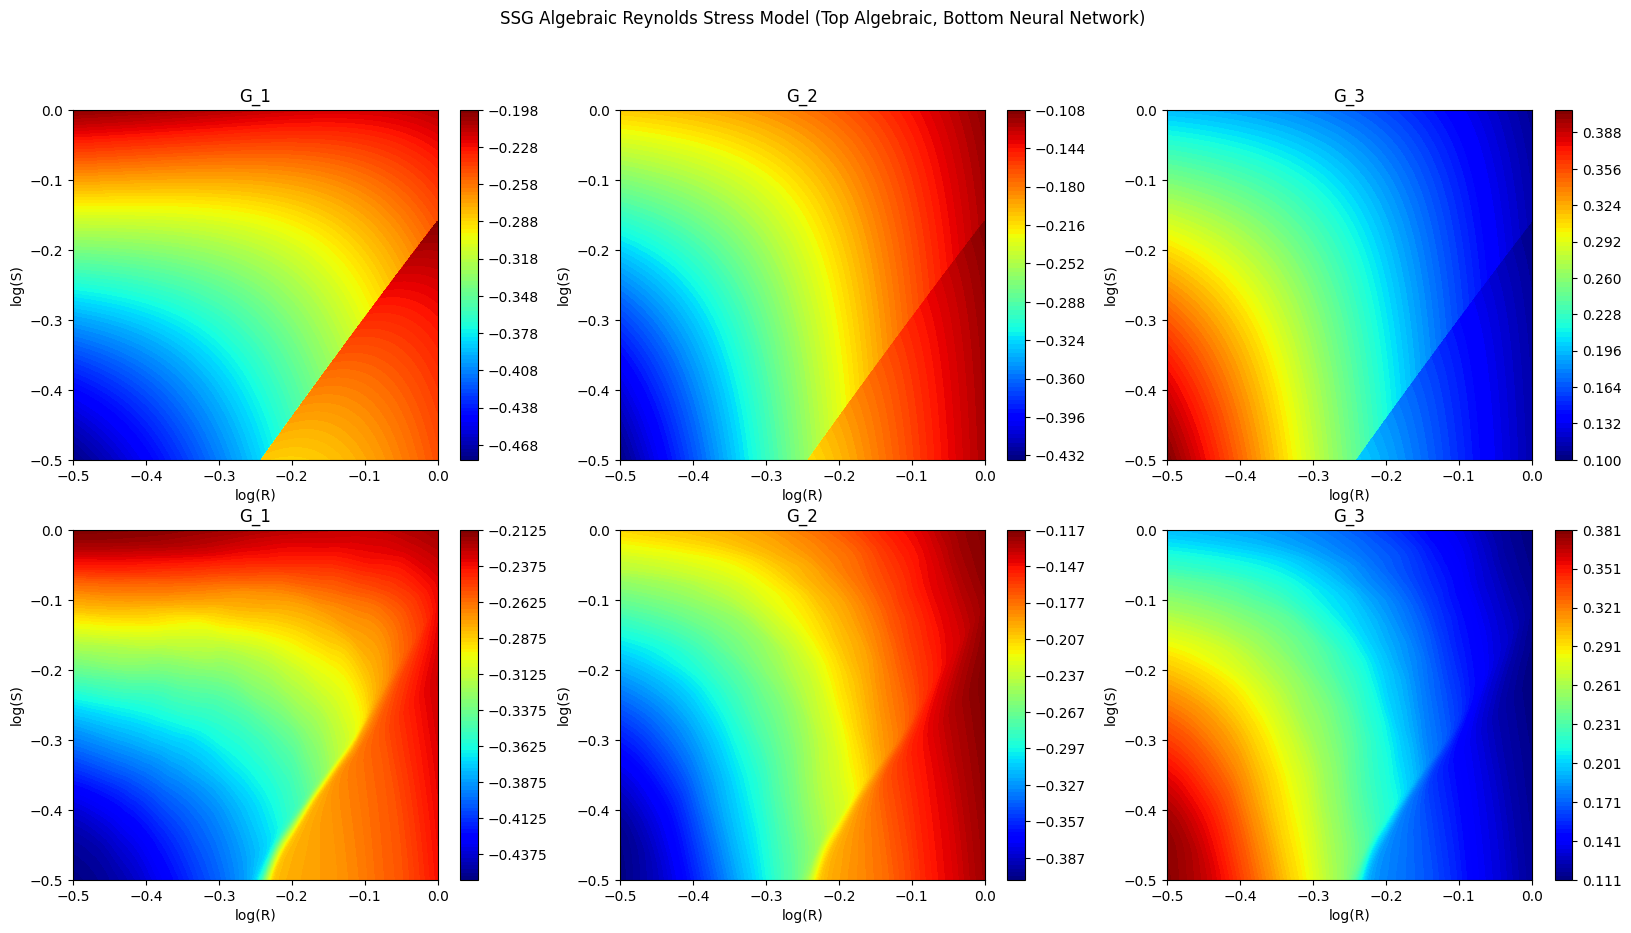

In [7]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s.T.reshape(3, dim, dim)

pred = net.predict(etas)

pred = pred.T.reshape(3, dim, dim)

plot_heat_map_compare(x_grid, y_grid, target, pred)


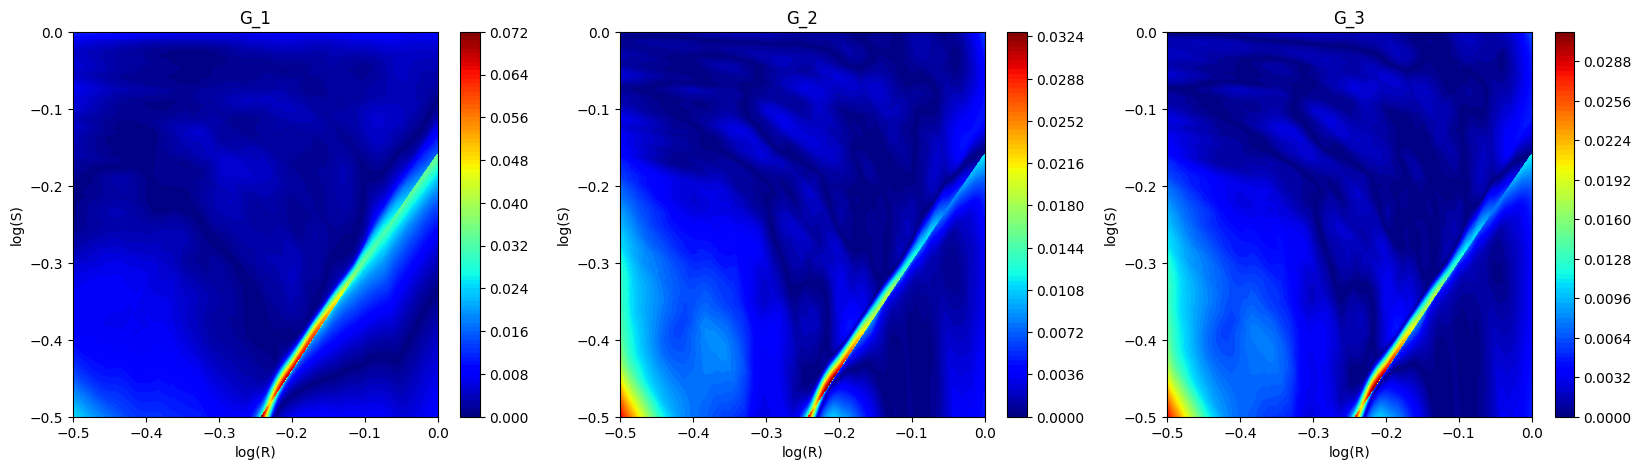

In [7]:
plot_heat_map_loss(x_grid, y_grid, target, pred)

del pred

## Generating Model Uncertainty From Dropout

In [10]:
T = 250
predictions = np.zeros((T, dim*dim, 3))

batch_size = dim*dim // 2


net.module.dropout_on(net_params['dropout'])

for i in range(T):
    batches = np.zeros((len(etas)//batch_size, batch_size , 3))
    for j in range(len(etas)//batch_size):
        batches[j] = net.module(torch.tensor(etas[j*batch_size:(j+1)*batch_size]).to(device)).cpu().detach()
    print(i)
    predictions[i] = batches.reshape(dim*dim, 3)
    del batches
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


In [11]:
mean_pred = np.mean(predictions, axis=0)

variance_pred = np.sum((predictions - mean_pred)**2, axis=0)/(T-1)

del predictions

### Variance vs Number of Training Points

Finished checkpoint TurbulenceNetwork_10.pt with max variance 0.0009794124827823287
Finished checkpoint TurbulenceNetwork_20.pt with max variance 0.0007411030979403476
Finished checkpoint TurbulenceNetwork_30.pt with max variance 0.0007449037786687422
Finished checkpoint TurbulenceNetwork_40.pt with max variance 0.0006494051593401962
Finished checkpoint TurbulenceNetwork_50.pt with max variance 0.000898833211190302
Finished checkpoint TurbulenceNetwork_60.pt with max variance 0.0004674832623224503
Finished checkpoint TurbulenceNetwork_70.pt with max variance 0.0010691886136385005
Finished checkpoint TurbulenceNetwork_80.pt with max variance 0.0008390742530115923
Finished checkpoint TurbulenceNetwork_90.pt with max variance 0.0005194500984544981
Finished checkpoint TurbulenceNetwork_100.pt with max variance 0.0009097536776355005
Finished checkpoint TurbulenceNetwork_110.pt with max variance 0.0007277535331306962
Finished checkpoint TurbulenceNetwork_120.pt with max variance 0.0008920348

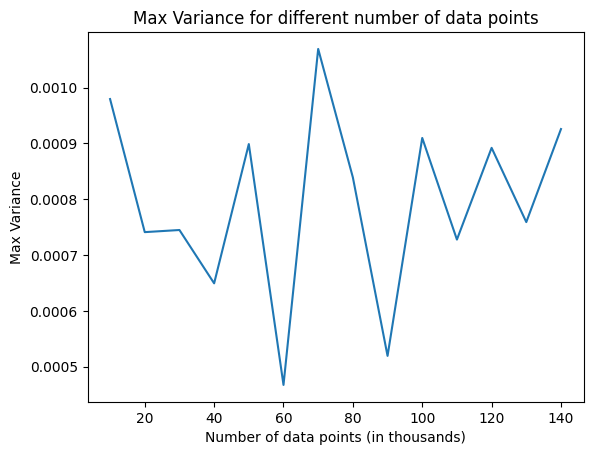

In [13]:
checkpoint_nums = np.arange(10, 150, 10)
checkpoints = [f'TurbulenceNetwork_{i}.pt' for i in checkpoint_nums]
T = 200
batch_size = dim*dim // 2

max_variances = []

for checkpoint in checkpoints:
    net = reinitialize_model(checkpoint, checkpoint_dir, TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
    net.module.dropout_on(net_params['dropout'])
    predictions = np.zeros((T, dim*dim, 3))
    for i in range(T):
        batches = np.zeros((len(etas)//batch_size, batch_size , 3))
        for j in range(len(etas)//batch_size):
            batches[j] = net.module(torch.tensor(etas[j*batch_size:(j+1)*batch_size]).to(device)).cpu().detach()
        predictions[i] = batches.reshape(dim*dim, 3)
        del batches
    mean_pred = np.mean(predictions, axis=0)
    estimated_variance = np.sum((predictions - mean_pred)**2, axis=0)/(T-1)
    max_variance = np.max(estimated_variance)
    print(f'Finished checkpoint {checkpoint} with max variance {max_variance}')
    max_variances.append(max_variance)
    del mean_pred
    del estimated_variance
    del predictions

plt.plot(checkpoint_nums, max_variances)
plt.xlabel("Number of data points (in thousands)")
plt.ylabel("Max Variance")
plt.title("Max Variance for different number of data points")
plt.show()


### Variance vs Number of Samples

Finished Num Samples: 25----- Max Variance: 0.0012082793753378878
Finished Num Samples: 50----- Max Variance: 0.001102663298185193
Finished Num Samples: 75----- Max Variance: 0.0009977817070245297
Finished Num Samples: 100----- Max Variance: 0.0009991699421830291
Finished Num Samples: 125----- Max Variance: 0.0009992951899640567
Finished Num Samples: 150----- Max Variance: 0.0009654610012404426
Finished Num Samples: 175----- Max Variance: 0.0010012219569633918
Finished Num Samples: 200----- Max Variance: 0.0009267555566157641
Finished Num Samples: 225----- Max Variance: 0.0009272158318311873
Finished Num Samples: 250----- Max Variance: 0.0009250482386028521


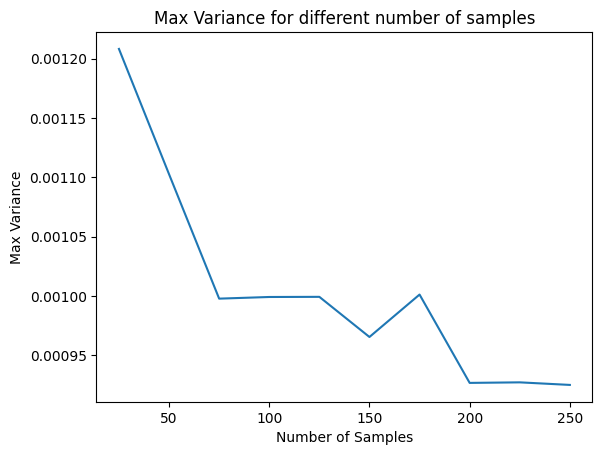

In [14]:
T_values = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250]
batch_size = dim*dim // 2
net = reinitialize_model('TurbulenceNetwork_100.pt', checkpoint_dir, TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)

max_variances = []

for T in T_values:
    predictions = np.zeros((T, dim*dim, 3))
    for i in range(T):
        batches = np.zeros((len(etas)//batch_size, batch_size , 3))
        for j in range(len(etas)//batch_size):
            batches[j] = net.module(torch.tensor(etas[j*batch_size:(j+1)*batch_size]).to(device)).cpu().detach()
        predictions[i] = batches.reshape(dim*dim, 3)
        del batches
    mean_pred = np.mean(predictions, axis=0)
    estimated_variance = np.sum((predictions - mean_pred)**2, axis=0)/(T-1)
    max_variance = np.max(estimated_variance)
    print(f'Finished Num Samples: {T}----- Max Variance: {max_variance}')
    max_variances.append(max_variance)
    del mean_pred
    del estimated_variance
    del predictions

plt.plot(T_values, max_variances)
plt.xlabel("Number of Samples")
plt.ylabel("Max Variance")
plt.title("Max Variance for different number of samples")
plt.show()

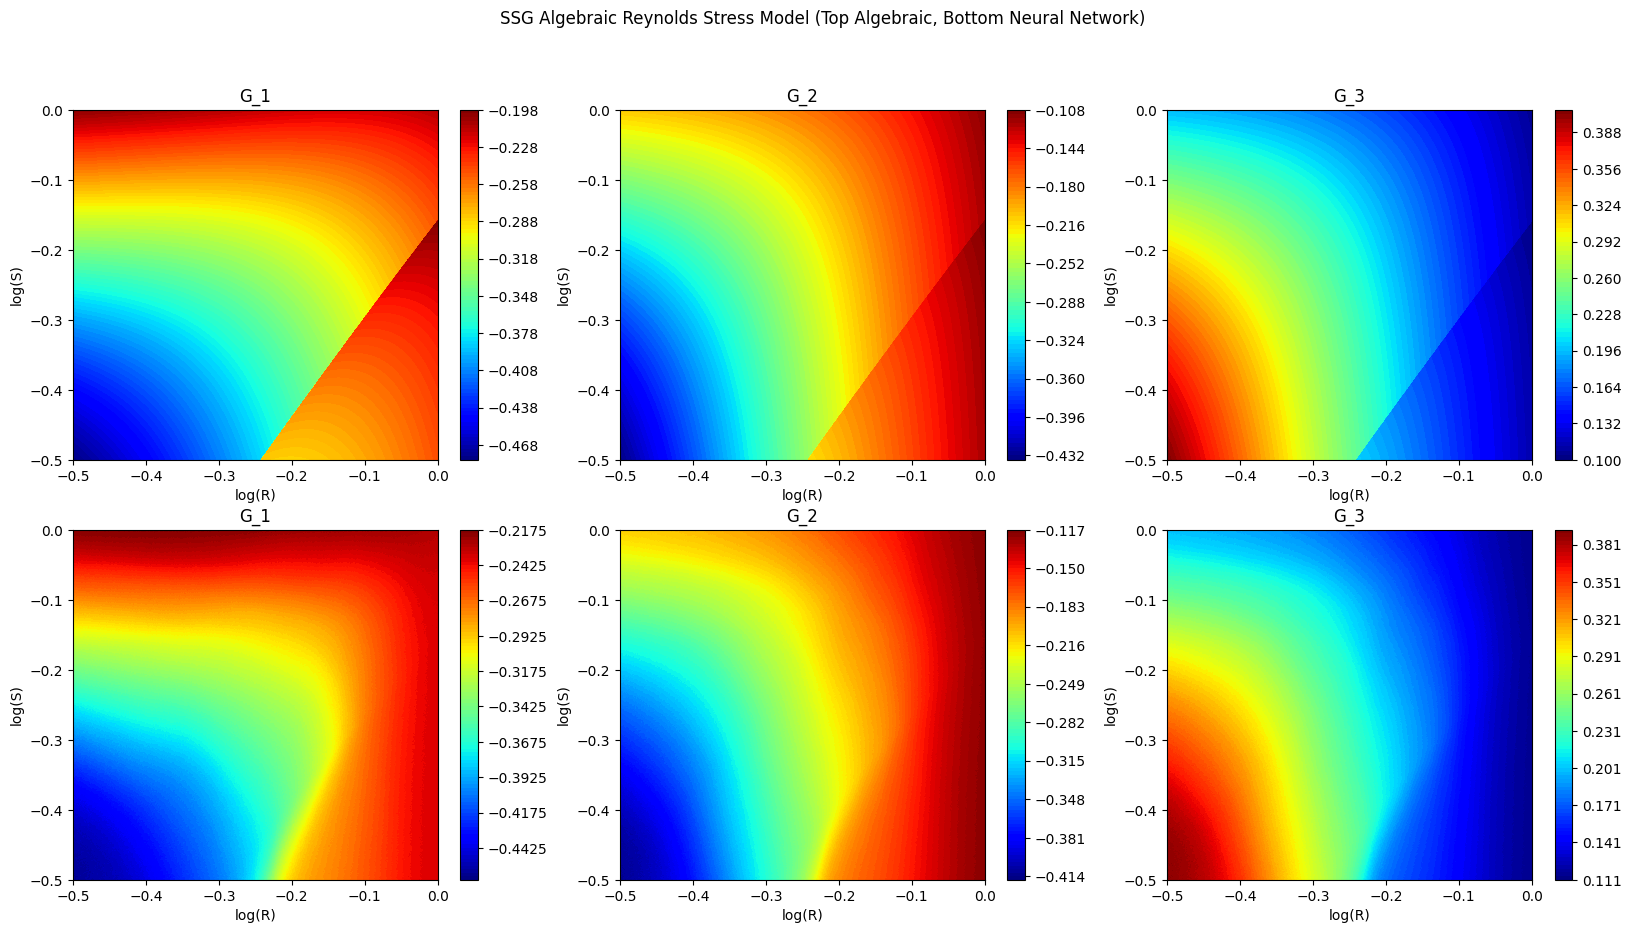

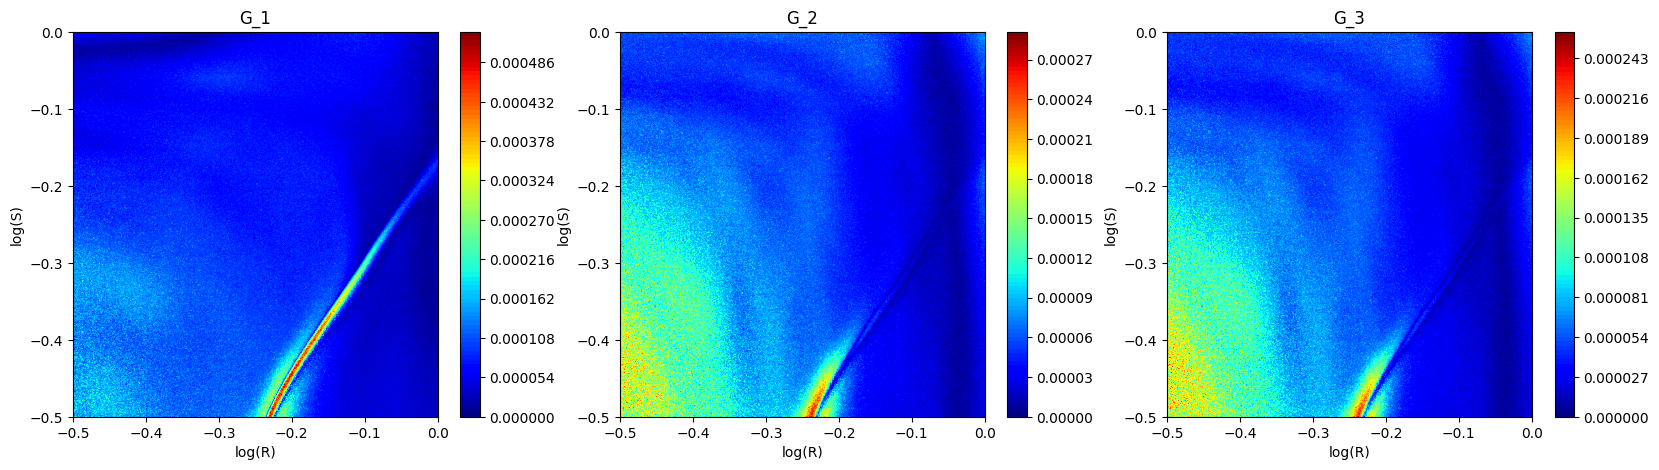

In [12]:
is_baseline = False

if is_baseline:
    np.savetxt('data/60k_Baseline_Mean.txt', mean_pred)
    np.savetxt('data/60k_Baseline_Var.txt', variance_pred)

plot_heat_map_compare(x_grid, y_grid, target, mean_pred.T.reshape(3, dim, dim))

if not is_baseline:
    baseline_var = np.loadtxt('data/60k_Baseline_Var.txt').T.reshape(3, dim, dim)
    plot_heat_map_loss(x_grid, y_grid, variance_pred.T.reshape(3, dim, dim), baseline_var)
else:
    plot_heat_map_3D(x_grid, y_grid, variance_pred.T.reshape(3, dim, dim))